In [1]:
import pygrnd


In [2]:
from pygrnd.optimize import MonteCarloGradientSearch
from pygrnd.optimize import MonteCarloSolver

import math
import cmath
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import norm

import dimod
import greedy
import timeit
from datetime import timedelta

from IPython.display import Image

In [3]:
# dwave classical gradient descent solver

def dwaveGreedySolver(m,N,verbose=False):
    if verbose:
        print("Starting Greedy Search")

    nonzeros=0
    mDict={}
    for i in range(len(m)):
        for j in range(len(m)):
            if abs(m[i,j])>0.01:
                nonzeros=nonzeros+1
                mDict[i,j]=m[i,j]

    if verbose:
        print("#nonzeros/#quboEntries: ",nonzeros,"/",len(m)**2)
        sparsity=100-100*nonzeros/(len(m)**2)
        print("sparsity              : ","%.2f%%" % (sparsity))

    mDict2={}
    mDict2Pair={}
    for x in mDict:
        if x[0]==x[1]:
            mDict2['x'+str(x[0])]=mDict[x]
        else:
            mDict2Pair['x'+str(x[0]),'x'+str(x[1])]=mDict[x]
    bqm=dimod.BinaryQuadraticModel(mDict2,mDict2Pair,"BINARY")
    
    solver=greedy.SteepestDescentSolver()
    sampleset=solver.sample(bqm,num_reads=N)
    best=sampleset.first
    res=[]
    for i in range(len(best.sample)):
        res.append(best.sample['x'+str(i)])
    #print(best.energy,[res[0],res[2],res[4],res[6],res[8]],[res[47],res[49],res[51],res[53],res[55]])
    #print(best.energy,res)

    
    return best.energy,res

In [4]:
def eval_solution(x,m):

    obj=np.matmul(np.matmul(x,m),np.transpose(x))

    return obj


## Baue Array mit allen möglichen 2^N Vektoren und multipliziere an Q, Iteriere durch alle Lösungsmöglichkeiten
def bruteForceSolver(m):

    menge=[p for p in itertools.product([0,1], repeat=len(m))]
    #bestCost=-math.inf # maximize
    bestCost=math.inf # minimize
    bestVector=0
    for x in menge:
        v=np.zeros((1,len(m)))
        for i in range(len(m)):
            v[0,i]=x[i]
        value=np.matmul(v,np.matmul(m,np.transpose(v)))
        if value<bestCost: #value>bestCost: <-- maximize   |   value<bestCost <-- minimize
            bestCost=value
            bestVector=x
    return bestVector,bestCost


def func_y(config):

    matr = np.array(m)

    return config @ matr @ config

def num_2_bin(num):

    bin_str = np.binary_repr(num, width=len(matr))
    bin_arr = np.array([int(x) for x in bin_str])

    return bin_arr



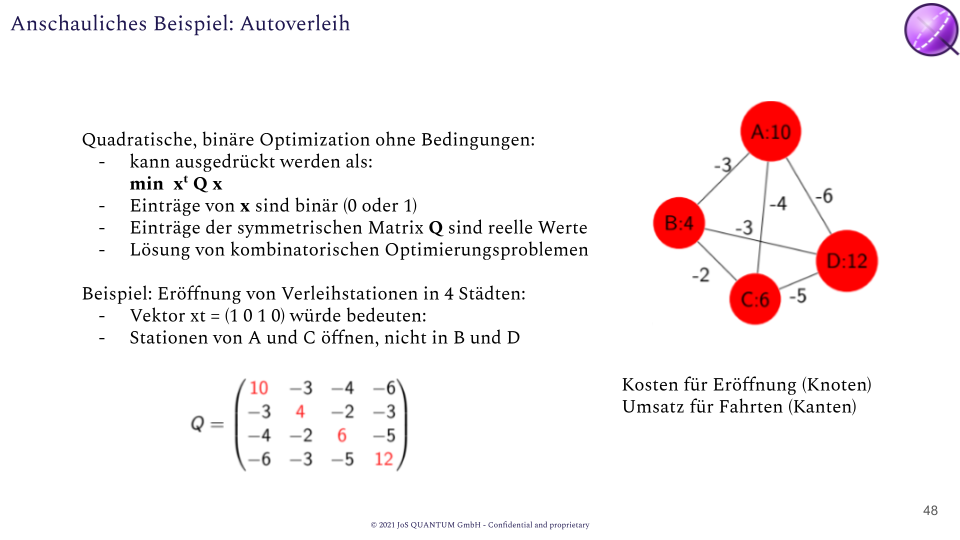

In [7]:
Image(filename='carstation_qubo.png',width=1000)

In [4]:
Q = np.array([[10,-3,-4,-6],[-3,4,-2,-3],[-4,-2,6,-5],[-6,-3,-5,12]])
print(Q)

[[10 -3 -4 -6]
 [-3  4 -2 -3]
 [-4 -2  6 -5]
 [-6 -3 -5 12]]


In [9]:
Qinv=Q*(-1)
print(Qinv)

[[-10   3   4   6]
 [  3  -4   2   3]
 [  4   2  -6   5]
 [  6   3   5 -12]]


Lösung des QUBO indem $x^t$ von Links und $x$ von Rechts multipilizert werden:

$ x^t Q x$

Beispiel:

$ x^t Q x = \begin{pmatrix} 1 & 0 & 1 & 0 \end{pmatrix}
\begin{pmatrix}
10 & -3 & -4 & -6 \\
-3 & 4 & -2 & -3 \\
-4 & -2 & 6 & -5 \\
-6 & -3 & -5 & 12
\end{pmatrix} \begin{pmatrix} 1 \\ 0 \\ 1 \\ 0 \end{pmatrix} = 8$

In [10]:
# Mögliche Lösung: Baue Verleihstation in Stadt A und C

eval_solution([1, 0, 1, 0],Q)

8

In [11]:
# Mögliche Lösung: Baue Verleihstation in Stadt A, B und C

eval_solution([1, 1, 1, 0],Q)

2

In [12]:
# Mögliche Lösung: Baue Verleihstation in Stadt B und C

eval_solution([0, 1, 1, 0],Q)

6

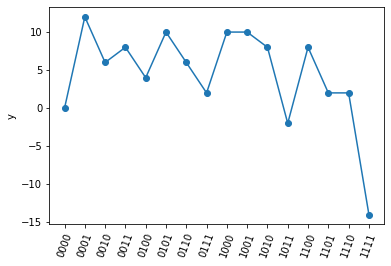

In [13]:
## Energielandschaft == Lösungswerte (y-Achse) VS Lösungsvektoren als Bit-string (x-Achse)

m=Q
matr = np.array(m)
y_vals = [func_y(num_2_bin(i)) for i in range(len(matr)*len(matr))]
bin_strings = ['{0:04b}'.format(i) for i in range(len(matr)*len(matr))]

plt.plot(y_vals,'o-')
plt.xticks(range(len(matr)*len(matr)), bin_strings, rotation=70);
plt.ylabel('y')
plt.show()

In [14]:
# brute force alle möglichen Lösungen

m=Q
menge=[p for p in itertools.product([0,1], repeat=len(m))]

for x in menge:
    v=np.zeros((1,len(m)))
    for i in range(len(m)):
        v[0,i]=x[i]
    print(v,np.matmul(v,np.matmul(m,np.transpose(v))))

[[0. 0. 0. 0.]] [[0.]]
[[0. 0. 0. 1.]] [[12.]]
[[0. 0. 1. 0.]] [[6.]]
[[0. 0. 1. 1.]] [[8.]]
[[0. 1. 0. 0.]] [[4.]]
[[0. 1. 0. 1.]] [[10.]]
[[0. 1. 1. 0.]] [[6.]]
[[0. 1. 1. 1.]] [[2.]]
[[1. 0. 0. 0.]] [[10.]]
[[1. 0. 0. 1.]] [[10.]]
[[1. 0. 1. 0.]] [[8.]]
[[1. 0. 1. 1.]] [[-2.]]
[[1. 1. 0. 0.]] [[8.]]
[[1. 1. 0. 1.]] [[2.]]
[[1. 1. 1. 0.]] [[2.]]
[[1. 1. 1. 1.]] [[-14.]]


In [15]:
bruteForceSolver(Q)

((1, 1, 1, 1), array([[-14.]]))

In [16]:
eval_solution([1, 1, 1, 1],Q)

-14

In [17]:
# Schreibweise für einen Quantenannealer (e.g. von D-Wave)

q=matrix_to_qubo(Q)
print(q)

NameError: name 'matrix_to_qubo' is not defined

In [14]:
# Lösung mittels Simuliertem Annealing

sol=anneal_qubo(q)
print(sol)

AnnealResults

  state: {0: 1, 1: 1, 2: 1, 3: 1}
  value: -14
   spin: False


In [15]:
## what if our matrix is 40 x 40?
# would require to build a 2^40 vector with 0 and 1 entries and multiply to Q according x^t Q x
# solving brute force not anymore possible with huge matrices

# Constraints

Unconstrained sind die wenigstens Optimierungsprobleme!

ABER: wir können Bedingungen durch Straftfaktoren einfügen

Beispiel: Bedingung zur Auswahl von genau 2 Städten:

$\sum_i x_i=2$

$\rightarrow (\sum_i x_i - 2)^2 = 0$

$\rightarrow \sum_i x_i \sum_j x_j - 4 \sum_i x_i + 4 = 0$

$\implies$ minimize $\sum_i x_i \sum_j x_j - 4 \sum_i x_i = 0$

(Am Ende muss der Offset $2^2$ abgezogen werden)

In [16]:
Qconstr=np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])-4*np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(Qconstr)

[[-3  1  1  1]
 [ 1 -3  1  1]
 [ 1  1 -3  1]
 [ 1  1  1 -3]]


Gleiches Prozedere wie vorher $x^t Q_{con} x$

QUBO für constrained problem: $Q = Q + Q_{con}$

Generell kann die Bedingung $P$ Mal addieren

$\rightarrow Q = Q + P Q_{con}$

Normalerweile werden diese Faktoren Strafaktoren genannt, da sie die Energielandschaft verzerren, sodass nicht gewünschte Lösungen vermieden werden

Optimierung der Straffaktoren! --> "hyperparameter tuning"

Bedingungen sollen eingehalten werden, es soll aber auch die optimale Lösung gefunden werden.

In [23]:
P=1

Qcon=Q+P*Qconstr
print(Qcon)

[[ 7 -2 -3 -5]
 [-2  1 -1 -2]
 [-3 -1  3 -4]
 [-5 -2 -4  9]]


In [24]:
qcon=matrix_to_qubo(Qcon)
solcon=anneal_qubo(qcon)
print(solcon)

AnnealResults

  state: {0: 1, 1: 1, 2: 1, 3: 1}
  value: -14
   spin: False


In [26]:
P=10

Qcon=Q+P*Qconstr
print(Qcon)

qcon=matrix_to_qubo(Qcon)
solcon=anneal_qubo(qcon)
print(solcon)

[[-20   7   6   4]
 [  7 -26   8   7]
 [  6   8 -24   5]
 [  4   7   5 -18]]
AnnealResults

  state: {0: 0, 1: 1, 2: 1, 3: 0}
  value: -34
   spin: False


In [32]:
eval_solution([0, 1, 1, 0],Qcon)

## 2^2*P = 40

## Die echte Lösung liegt also bei -34 + 40 = 6

-34

## solving QUBOs


| method | availability | pros/cons |
|-----------|--------------|-----------|
|brute force|available|exact / slow|
random trials|available|fast / no control|
sim. annealing|available|fast / limited control|
annealing|available|fast, scales well / limited size, limited control|
quantum annealing|available|fast, scales well / limited size, limited control|
quantum inspired|available|fast, scales well
variational quantum eigensolver|toy version|fast
quantum approximate optimization algorithm|toy version|fast


## Qubos -> Ising -> Annealing

Ising model: interacting spins

$H=-x^tJx-hx$

vectors have entries -1 or 1

Change of variable turns QUBO into Ising model

--> Annealers are implementations of Ising models

## Annealing

Problem we want to solve is interpreted as a physical system where the solutions represents the minimum/maximum of an energy function ~ cost function

The probability to find a system in a certain state:

$P \propto e^{\frac{-H}{kT}}$

Transition probabilties W between states S, S'

$\frac{W(S->S')}{W(S'->S)} = \frac{e^{\frac{-H(S')}{kT}}}{e^{\frac{-H(S)}{kT}}}$

 --> So states of higher energy are more likely to go to a state of lower energy than the other way around. The lower the temp, the more pronounced this effect is.

 --> Annealing: lower temp to let nature find the state of lowest energy 

 --> Annealing schedule: how to lower temp. slower = better.

In [8]:
Q

array([[10, -3, -4, -6],
       [-3,  4, -2, -3],
       [-4, -2,  6, -5],
       [-6, -3, -5, 12]])

In [9]:
from pygrnd.optimize.MonteCarloGradientSearch import *
from pygrnd.optimize.MonteCarloSolver import *
import numpy as np

MCgradientSearch(Q,10)

(6.0, array([1., 1., 1., 1.]))

In [11]:
MCgradientSearch(Q,10)

(-2.0, array([1., 0., 1., 1.]))

In [5]:
dwaveGreedySolver(Q,10,verbose=True)

Starting Greedy Search
#nonzeros/#quboEntries:  16 / 16
sparsity              :  0.00%


(-14.0, [1, 1, 1, 1])